In [2]:
import torch
import sklearn
import sys
from tqdm import tqdm_notebook as tqdm
import random
import numpy as np
from torch.utils.data import Dataset, Subset
from torch.utils.data import TensorDataset, DataLoader
import torch.backends.cudnn as cudnn
from torch import nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
def example_dl(sample_num, transform=None):
    w = [2,-3.4]
    b = 4.2
    y = []

    x = np.random.normal(0,1,(sample_num,2))

    y.append(x @ w + b + np.random.normal(0,0.01,sample_num))
    
    x = torch.tensor(x.astype(np.float32))
    y = torch.tensor(np.array(y, dtype='float32'))

    dataset = torch.utils.data.TensorDataset(x.reshape(-1,2).unsqueeze(0),y.reshape(-1,1).unsqueeze(0))

    return dataset

In [4]:
# make dataloader
def create_dataloader(dataset_name, transform, valid=False):
    test_dl, valid_dl = None, None

    if dataset_name == 'MNIST':
        train_datasets = datasets.FashionMNIST(root='../datasets', train=True, download=True, transform=transform)
        if valid:
            n_samples = len(train_datasets)
            train_size = int(n_samples * 0.8)
            subset1_indices = list(range(0,train_size))
            subset2_indices = list(range(train_size,n_samples))

            train_dataset = Subset(train_datasets, subset1_indices)
            valid_dataset = Subset(train_datasets, subset2_indices)

            train_dl = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
            valid_dl = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
        else:
            train_dl = DataLoader(train_datasets,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dataset = datasets.FashionMNIST(root='../datasets', train=False, download=True, transform=transform)
        test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    if dataset_name == 'example':
        train_dataset = example_dl(1000)
        train_dl = DataLoader(train_dataset,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    
    return train_dl, test_dl, valid_dl



In [5]:
#models
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(2,1)
        nn.init.normal_(self.linear.weight, 0.0, 0.01)
    def forward(self, x):
        y = self.linear(x)
        return y

class SingleModel(torch.nn.Module):
    def __init__(self):
       super(SingleModel, self).__init__()
       self.fc = torch.nn.Linear(784, 10, bias=True)
       self.softmax = nn.Softmax()
       nn.init.normal_(self.fc.weight, 0.0, 0.01)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        y = self.fc(x)
        y = self.softmax(y)
        return y

class MultPerceptronModel(torch.nn.Module):
    def __init__(self):
       super(MultPerceptronModel, self).__init__()
       self.fc1 = nn.Linear(784, 256, bias=True)
       self.fc2 = nn.Linear(256, 10, bias=True)
       self.relu = nn.ReLU()
       self.softmax = nn.Softmax()
       nn.init.normal_(self.fc1.weight, 0.0, 0.01)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        y = self.fc1(x)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.softmax(y)
        return y


class DropoutModel(torch.nn.Module):
    def __init__(self, p=0.5):
       super(DropoutModel, self).__init__()
       self.fc1 = nn.Linear(784, 256, bias=True)
       self.fc2 = nn.Linear(256, 10, bias=True)
       self.drop = nn.Dropout(p=p)
       self.relu = nn.ReLU()
       self.softmax = nn.Softmax()
       nn.init.normal_(self.fc1.weight, 0.0, 0.01)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        y = self.fc1(x)
        y = self.relu(y)
        y = self.drop(y)
        y = self.fc2(y)
        y = self.softmax(y)
        return y

In [6]:
def one_epoch(model, dl, device, criterion, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    losses = 0
    data_num = 0
    correct_num = 0
    iter_num = 0

    for datas, targets in dl:
        datas, targets = datas.to(device), targets.to(device)
        data_num += len(targets)
        iter_num += 1

        if optimizer:
            logits = model(datas)
            loss = criterion(logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(datas)
                loss = criterion(logits, targets)
            
        losses += loss.item()

        if criterion != nn.MSELoss():
            prediction = torch.argmax(logits,dim=1)
            correct_num += (prediction == targets).sum().item()
    return losses/iter_num, correct_num/data_num
        

In [7]:
def train(model, train_dl, test_dl, epoch, device, criterion, optimizer, early_stop=5, valid_dl=None):

    train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = [],[],[],[]
    best_train_loss, best_train_acc, best_test_loss, best_test_acc = None, None, None, None
    best_valid_loss = None
    count = 0
    
    for i in range(epoch):
        train_loss, train_acc = one_epoch(model, train_dl, device, criterion, optimizer)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_acc)

        if i==0 or best_train_loss >= train_loss:
            best_train_loss = train_loss
            best_train_acc = train_acc
        test_loss, test_acc = one_epoch(model, test_dl, device, criterion)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_acc)

        if i==0 or best_test_loss >= test_loss:
            best_test_loss = test_loss
            best_test_acc = test_acc

        if i%5 == 0:
            print('EPOCH:{:}, Train: loss={:.3}, acc={:.3%} Test: loss={:.3}, acc={:.3%}'.format(i,train_loss, train_acc, test_loss, test_acc))
        
        if valid_dl:
            valid_loss, valid_acc = one_epoch(model, valid_dl, device, criterion)

            if i==0 or best_valid_loss >= valid_loss:
                best_valid_loss = valid_loss
                count = 0
            else:
                count += 1
                print('early stopping count = {:}'.format(count))
        
            if count >= early_stop:
                print('early stoping : final epoch = {:}'.format(i))
                break   
    
    print('Best train loss={:.3} Best test loss={:.3}'.format(best_train_loss, best_test_loss))
    print('Best train accuracy={:.3} Best test accuracy={:.3}'.format(best_train_acc, best_test_acc))

    return np.array(train_loss_list), np.array(test_loss_list), np.array(train_accuracy_list), np.array(test_accuracy_list)

In [8]:
# Constants
TRAIN_BATCH_SIZE = 256
VALID_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

EPOCH:0 Train: loss=29.2
EPOCH:10 Train: loss=0.351
EPOCH:20 Train: loss=0.00438
EPOCH:30 Train: loss=0.000157
EPOCH:40 Train: loss=0.000105
Best train loss=0.000104


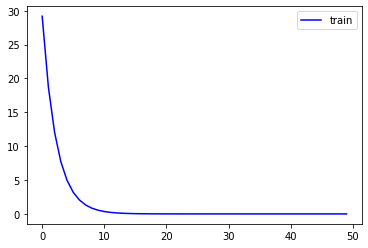

model weight: Parameter containing:
tensor([[ 2.0003, -3.4005]], device='cuda:0', requires_grad=True)
model bias: Parameter containing:
tensor([4.2002], device='cuda:0', requires_grad=True)


In [9]:
#Q1: Linear Regression

EPOCH_NUM = 50

transform = transforms.Compose(
    [transforms.ToTensor()])
train_dl, _, _ = create_dataloader('example', transform=None)


model = LinearRegression()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list = []
best_train_loss = None

epoch = EPOCH_NUM
for i in range(epoch):
    train_loss, _ = one_epoch(model, train_dl, device, criterion, optimizer)
    train_loss_list.append(train_loss)

    if i==0 or best_train_loss >= train_loss:
            best_train_loss = train_loss

    if i%10 == 0:
        print('EPOCH:{:} Train: loss={:.3}'.format(i,train_loss))

print('Best train loss={:.3}'.format(best_train_loss))

fig, ax = plt.subplots()
ax.plot(train_loss_list, 'b', label='train')
ax.legend()
plt.show()

print("model weight:", model.linear.weight)
print("model bias:", model.linear.bias)


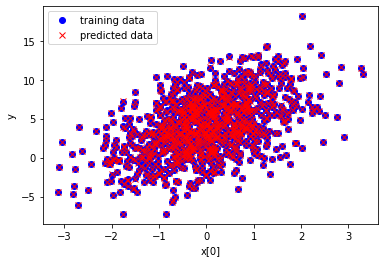

In [35]:

x_train = train_dl.dataset.tensors[0].detach().numpy().reshape(-1,2)
y_train = train_dl.dataset.tensors[1].detach().numpy().reshape(-1)

y_pred = []
for datas, targets in train_dl:
        datas, targets = datas.to(device), targets.to(device)
        
        with torch.no_grad():
            logits = model(datas)
            y_pred.append(logits.cpu().numpy().reshape(-1))
y_pred = np.array(y_pred).reshape(-1)

fig, ax = plt.subplots()
ax.plot(x_train[:,0], y_train, "bo", label="training data")
ax.plot(x_train[:,0], y_pred, "rx", label="predicted data")
ax.set_xlabel("x[0]")
ax.set_ylabel("y")
ax.legend()
plt.show()

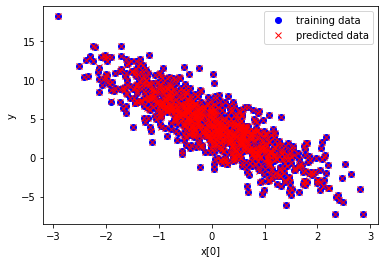

In [36]:
fig, ax = plt.subplots()
ax.plot(x_train[:,1], y_train, "bo", label="training data")
ax.plot(x_train[:,1], y_pred, "rx", label="predicted data")
ax.set_xlabel("x[0]")
ax.set_ylabel("y")
ax.legend()
plt.show()

/home/miki225/miki/myvenv/rinkovenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH:0, Train: loss=1.98, acc=55.867% Test: loss=1.88, acc=62.520%
EPOCH:5, Train: loss=1.78, acc=71.793% Test: loss=1.75, acc=75.180%
EPOCH:10, Train: loss=1.71, acc=78.375% Test: loss=1.71, acc=77.750%
EPOCH:15, Train: loss=1.69, acc=79.237% Test: loss=1.7, acc=78.560%
EPOCH:20, Train: loss=1.69, acc=79.745% Test: loss=1.69, acc=79.130%
EPOCH:25, Train: loss=1.68, acc=80.105% Test: loss=1.68, acc=79.330%
EPOCH:30, Train: loss=1.68, acc=80.347% Test: loss=1.68, acc=79.530%
EPOCH:35, Train: loss=1.67, acc=80.548% Test: loss=1.68, acc=79.690%
EPOCH:40, Train: loss=1.67, acc=80.752% Test: loss=1.68, acc=79.830%
EPOCH:45, Train: loss=1.67, acc=80.927% Test: loss=1.67, acc=79.950%
EPOCH:50, Train: loss=1.67, acc=81.017% Test: loss=1.67, acc=80.090%
EPOCH:55, Train: loss=1.66, acc=8

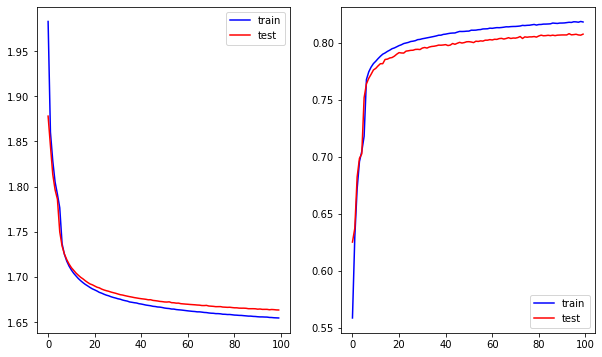

In [36]:
#Q2: Softmax Regression
EPOCH_NUM = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, _ = create_dataloader('MNIST', transform)

model = SingleModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train(model, train_dl, test_dl, EPOCH_NUM, device, criterion, optimizer)

fig= plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss_list, 'b', label='train')
ax1.plot(test_loss_list, 'r', label='test')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_accuracy_list, 'b', label='train')
ax2.plot(test_accuracy_list, 'r', label='test')
ax2.legend()
plt.show()


/home/miki225/miki/myvenv/rinkovenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/home/miki225/miki/myvenv/rinkovenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



<AxesSubplot:>

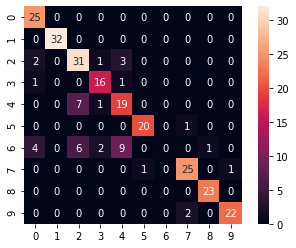

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = []
corrects = []

for datas, targets in tqdm_notebook(test_dl):
    datas, targets = datas.to(device), targets.to(device)

    with torch.no_grad():
        logits = model(datas)
    
    pred = torch.argmax(logits, dim=1)
    predictions.append(pred.cpu().numpy())
    corrects.append(targets.cpu().numpy())


predictions = predictions[0]
corrects = corrects[0]

cm = confusion_matrix(corrects, predictions)
sns.heatmap(cm, annot=True, square=True)


ipykernel_launcher:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH:0, Train: loss=2.14, acc=39.258% Test: loss=1.92, acc=61.930%
EPOCH:5, Train: loss=1.7, acc=78.547% Test: loss=1.7, acc=77.960%
EPOCH:10, Train: loss=1.67, acc=80.202% Test: loss=1.68, acc=79.450%
EPOCH:15, Train: loss=1.66, acc=80.955% Test: loss=1.67, acc=79.870%
EPOCH:20, Train: loss=1.65, acc=81.432% Test: loss=1.66, acc=80.670%
EPOCH:25, Train: loss=1.65, acc=81.795% Test: loss=1.66, acc=80.760%
EPOCH:30, Train: loss=1.65, acc=82.068% Test: loss=1.66, acc=80.680%
EPOCH:35, Train: loss=1.64, acc=82.342% Test: loss=1.66, acc=80.990%
EPOCH:40, Train: loss=1.64, acc=82.457% Test: loss=1.65, acc=81.390%
EPOCH:45, Train: loss=1.64, acc=82.747% Test: loss=1.65, acc=81.490%
EPOCH:50, Train: loss=1.64, acc=82.890% Test: loss=1.65, acc=81.550%
EPOCH:55, Train: loss=1.64, acc=83.050% Test: loss=1.65, acc=81.450%
EPOCH:60, Train: loss=1.64, acc=

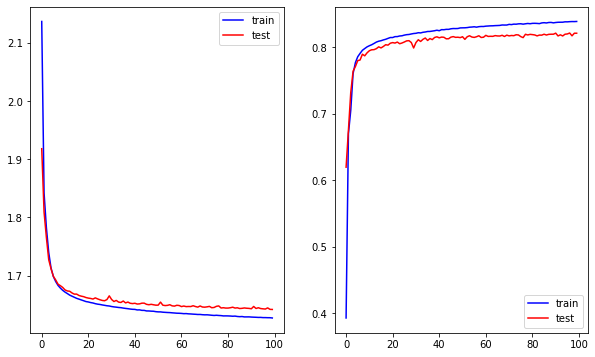

In [9]:
#Q3: Multilayer Perceptrons

EPOCH_NUM = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, _ = create_dataloader('MNIST', transform)

model = MultPerceptronModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train(model, train_dl, test_dl, EPOCH_NUM, device, criterion, optimizer)

fig= plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss_list, 'b', label='train')
ax1.plot(test_loss_list, 'r', label='test')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_accuracy_list, 'b', label='train')
ax2.plot(test_accuracy_list, 'r', label='test')
ax2.legend()
plt.show()

ipykernel_launcher:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH:0, Train: loss=2.15, acc=38.978% Test: loss=1.97, acc=55.170%
EPOCH:5, Train: loss=1.72, acc=76.695% Test: loss=1.71, acc=76.990%
EPOCH:10, Train: loss=1.68, acc=79.067% Test: loss=1.68, acc=79.090%
EPOCH:15, Train: loss=1.67, acc=80.035% Test: loss=1.67, acc=79.670%
EPOCH:20, Train: loss=1.66, acc=80.593% Test: loss=1.66, acc=80.340%
EPOCH:25, Train: loss=1.66, acc=80.997% Test: loss=1.66, acc=80.640%
EPOCH:30, Train: loss=1.65, acc=81.475% Test: loss=1.66, acc=81.010%
EPOCH:35, Train: loss=1.65, acc=81.645% Test: loss=1.65, acc=81.060%
EPOCH:40, Train: loss=1.65, acc=81.918% Test: loss=1.65, acc=81.220%
EPOCH:45, Train: loss=1.65, acc=82.138% Test: loss=1.65, acc=81.470%
EPOCH:50, Train: loss=1.64, acc=82.313% Test: loss=1.65, acc=81.340%
EPOCH:55, Train: loss=1.64, acc=82.415% Test: loss=1.65, acc=81.760%
EPOCH:60, Train: loss=1.64, ac

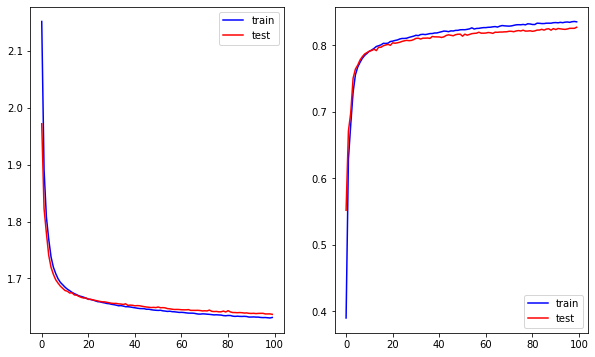

In [56]:
#Q4: Regularization
# Dropout
EPOCH_NUM = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, _ = create_dataloader('MNIST', transform)

model = DropoutModel(p=0.5)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train(model, train_dl, test_dl, EPOCH_NUM, device, criterion, optimizer)

fig= plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss_list, 'b', label='train')
ax1.plot(test_loss_list, 'r', label='test')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_accuracy_list, 'b', label='train')
ax2.plot(test_accuracy_list, 'r', label='test')
ax2.legend()
plt.show()

ipykernel_launcher:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH:0, Train: loss=2.16, acc=40.681% Test: loss=1.95, acc=59.960%
EPOCH:5, Train: loss=1.72, acc=77.487% Test: loss=1.71, acc=77.250%
early stopping count = 1
EPOCH:10, Train: loss=1.68, acc=79.744% Test: loss=1.68, acc=78.890%
EPOCH:15, Train: loss=1.67, acc=80.531% Test: loss=1.67, acc=79.620%
early stopping count = 1
early stopping count = 1
EPOCH:20, Train: loss=1.66, acc=81.065% Test: loss=1.67, acc=80.350%
early stopping count = 1
early stopping count = 1
EPOCH:25, Train: loss=1.65, acc=81.456% Test: loss=1.66, acc=80.150%
early stopping count = 1
EPOCH:30, Train: loss=1.65, acc=81.685% Test: loss=1.66, acc=80.420%
early stopping count = 1
EPOCH:35, Train: loss=1.65, acc=81.994% Test: loss=1.66, acc=80.890%
early stopping count = 1
early stopping count = 2
early stopping count = 1
early stopping count = 2
EPOCH:40, Train: loss=1.65, acc

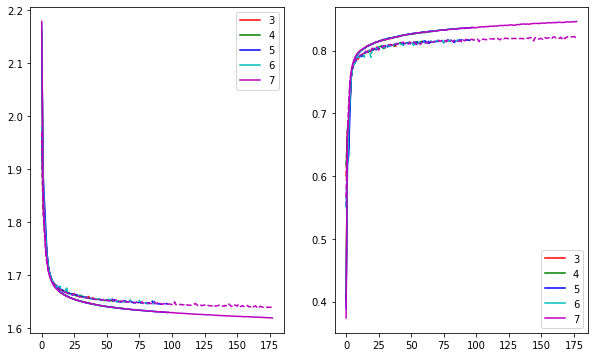

In [14]:
#Q4: Regularization
# early stopping
EPOCH_NUM = 300

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, valid_dl = create_dataloader('MNIST', transform, valid=True)

fig= plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
colorlist = ['r', 'g', 'b', 'c', 'm']

for c in range(5):
    model = MultPerceptronModel()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.00001)
    train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train(model, train_dl, test_dl, EPOCH_NUM, device, criterion, optimizer, early_stop=c+3, valid_dl=valid_dl)

    ax1.plot(train_loss_list, colorlist[c], label=c+3)
    ax1.plot(test_loss_list, colorlist[c],linestyle='dashed')
    ax2.plot(train_accuracy_list, colorlist[c], label=c+3)
    ax2.plot(test_accuracy_list, colorlist[c],linestyle='dashed')

ax1.legend()
ax2.legend()
plt.show()

0.1
ipykernel_launcher:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH:0, Train: loss=2.29, acc=22.805% Test: loss=2.29, acc=19.850%
EPOCH:5, Train: loss=2.24, acc=18.253% Test: loss=2.24, acc=18.520%
EPOCH:10, Train: loss=2.23, acc=19.982% Test: loss=2.23, acc=19.980%
EPOCH:15, Train: loss=2.23, acc=19.975% Test: loss=2.22, acc=19.970%
EPOCH:20, Train: loss=2.23, acc=19.980% Test: loss=2.23, acc=19.970%
EPOCH:25, Train: loss=2.23, acc=19.978% Test: loss=2.23, acc=19.960%
EPOCH:30, Train: loss=2.23, acc=19.977% Test: loss=2.23, acc=19.970%
EPOCH:35, Train: loss=2.23, acc=19.977% Test: loss=2.23, acc=19.980%
EPOCH:40, Train: loss=2.23, acc=19.975% Test: loss=2.23, acc=19.920%
EPOCH:45, Train: loss=2.23, acc=19.977% Test: loss=2.23, acc=19.970%
EPOCH:50, Train: loss=2.23, acc=19.978% Test: loss=2.23, acc=19.970%
EPOCH:55, Train: loss=2.23, acc=19.975% Test: loss=2.23, acc=19.960%
EPOCH:60, Train: loss=2.23

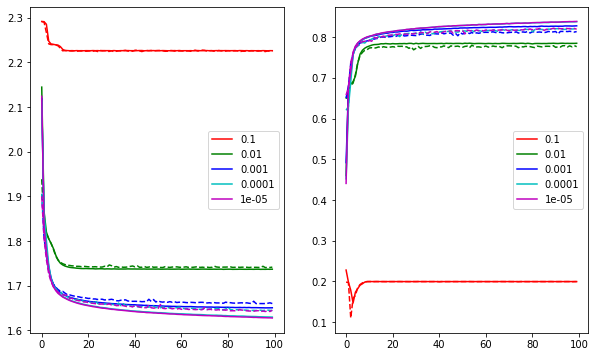

In [13]:
#Q4: Regularization
# weight_decay
EPOCH_NUM = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, _ = create_dataloader('MNIST', transform)

fig= plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
colorlist = ['r', 'g', 'b', 'c', 'm']

for wd in range(len(colorlist)):
    model = MultPerceptronModel()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=10**(-(wd+1)))
    print(10**(-(wd+1)))

    train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train(model, train_dl, test_dl, EPOCH_NUM, device, criterion, optimizer)

    ax1.plot(train_loss_list, colorlist[wd], label=10**(-(wd+1)))
    ax1.plot(test_loss_list, colorlist[wd],linestyle='dashed')
    ax2.plot(train_accuracy_list, colorlist[wd], label=10**(-(wd+1)))
    ax2.plot(test_accuracy_list, colorlist[wd],linestyle='dashed')

ax1.legend()
ax2.legend()
plt.show()